In [202]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import mode
import editdistance
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from joblib import Parallel, delayed
import pybedtools

In [180]:
ROOT = Path().cwd()
PREPROCESSING = Path("../preprocessing")
ASSEMBLING = Path("../reference_genomes")
DATA = Path("../data")
CLADE_FASTA = DATA / "multifasta_for_clades"
ALIGNMENTS = DATA / "alignments"
CONSENSUSES = DATA / "consensuses"

In [181]:
for name in PREPROCESSING, ASSEMBLING, DATA, CLADE_FASTA, ALIGNMENTS, CONSENSUSES:
    name.mkdir(parents=True, exist_ok=True)

In [10]:
for to_ref in ASSEMBLING.glob("*.fasta"):
    print("\n")
    for to_clade in sorted(CLADE_FASTA.glob("clade_*merge.fasta")):
        to_align = ALIGNMENTS / to_ref.stem / f"{to_clade.name.split('.fasta')[0]}_align.fasta"
        if to_align.exists():
            print(f"{to_align.name} for {to_ref.name} exists")
            continue
        to_align.parent.mkdir(exist_ok=True, parents=True)
        !mafft --reorder --localpair --quiet --thread 144 --maxambiguous 0.05 --addfragments {to_clade} --auto {to_ref}  > {to_align}



clade_1-merge_align.fasta for DQ008354.1.fasta exists
clade_2-merge_align.fasta for DQ008354.1.fasta exists
clade_3-merge_align.fasta for DQ008354.1.fasta exists
clade_4-merge_align.fasta for DQ008354.1.fasta exists
clade_5-merge_align.fasta for DQ008354.1.fasta exists
clade_6-merge_align.fasta for DQ008354.1.fasta exists
clade_8-merge_align.fasta for DQ008354.1.fasta exists
clade_9-merge_align.fasta for DQ008354.1.fasta exists


clade_1-merge_align.fasta for NC_001348.1.fasta exists
clade_2-merge_align.fasta for NC_001348.1.fasta exists
clade_3-merge_align.fasta for NC_001348.1.fasta exists
clade_4-merge_align.fasta for NC_001348.1.fasta exists
clade_5-merge_align.fasta for NC_001348.1.fasta exists
clade_6-merge_align.fasta for NC_001348.1.fasta exists
clade_8-merge_align.fasta for NC_001348.1.fasta exists
clade_9-merge_align.fasta for NC_001348.1.fasta exists


In [4]:
def alignment_to_np(to_align):
    align_np = [np.frombuffer(seq_record.seq.encode('utf-8'), dtype=np.int8) for seq_record in SeqIO.parse(to_align, "fasta")]
    align_np = np.stack(align_np)
    return align_np

In [5]:
def delete_insertions(align_np):
    mask = np.isin(align_np[0], np.frombuffer("-".encode('utf-8'), dtype=np.int8))
    return align_np[:, ~mask]

In [6]:
def to_consensus(align_np):
    consensus_np = mode(align_np[1:], axis=0, keepdims=False)
    return consensus_np

In [7]:
def consensus_to_seq(consensus_np):
    #consensus = Seq(consensus_np.mode.tobytes().decode("utf-8"))
    consensus = Seq(consensus_np.tobytes().decode("utf-8"))
    return consensus

In [105]:
def job(to_align):
    align_np = alignment_to_np(to_align)
    align_np_modif = delete_insertions(align_np)
    consensus_np = to_consensus(align_np_modif)
    #consensus = consensus_to_seq(consensus_np)
    to_save = DATA / "consensuses" / to_align.parent.name / f"{to_align.name.split('-')[0]}_consensus.npy"
    if to_save.exists():
        print(f"{to_save.name} exists")
        return
    to_save.parent.mkdir(exist_ok=True, parents=True)
    return np.save(to_save, consensus_np.mode)

In [61]:
%%time
with Parallel(n_jobs=40) as pool:
    for to_ref in ASSEMBLING.glob("*.fasta"):
        chunks = pool(
            delayed(job)(to_align)
            for to_align in sorted((ALIGNMENTS / to_ref.stem).glob("*merge_align.fasta"))
    )

CPU times: user 74.8 ms, sys: 7.13 ms, total: 81.9 ms
Wall time: 8.07 s


In [8]:
consensuses_by_ref = {}
for to_ref in ASSEMBLING.glob("*.fasta"):
    consensuses = np.stack([consensus_to_seq(np.load(to_consensus)) for to_consensus in sorted(CONSENSUSES.joinpath(to_ref.stem).glob("*consensus.npy"))])
    consensuses_by_ref[to_ref.stem] = consensuses

In [9]:
consensuses_by_ref.keys()

dict_keys(['DQ008354.1', 'NC_001348.1'])

In [28]:
consensuses_by_ref["NC_001348.1"][0].shape

(124884,)

In [10]:
ref_DQ = [seq_record for seq_record in SeqIO.parse(ASSEMBLING / "DQ008354.1.fasta", "fasta")][0]
ref_NC = [seq_record for seq_record in SeqIO.parse(ASSEMBLING / "NC_001348.1.fasta", "fasta")][0]

assert consensuses_by_ref["DQ008354.1"].shape[1] == len(ref_DQ.seq)
assert consensuses_by_ref["NC_001348.1"].shape[1] == len(ref_NC.seq)

In [11]:
positions = [33676-1, 37853-1, 38006-1, 52365-1, 69424-1, 98362-1, 114639-1]
consensuses_by_ref["DQ008354.1"][:, positions]
# совпадает не всё

array([['t', 'a', 't', 'c', 't', 't', 'a'],
       ['c', 'g', 'c', 'c', 't', 'c', 'a'],
       ['c', 'a', 't', 'c', 't', 't', 'a'],
       ['c', 'a', 'c', 'c', 't', 'c', 'a'],
       ['c', 'a', 't', 'c', 't', 't', 'a'],
       ['c', 'a', 't', 'c', 't', 'c', 'a'],
       ['c', 'a', 't', 'c', 't', 'c', 'a'],
       ['c', 'a', 'c', 'c', 't', 'c', 'a']], dtype='<U1')

In [12]:
positions = [33725-1, 37902-1, 38055-1, 52365-1, 69424-1, 98437-1, 114639-1]
consensuses_by_ref["NC_001348.1"][:, positions]
# всё совпало

array([['t', 'a', 't', 'c', 'g', 't', 't'],
       ['c', 'g', 'c', 'c', 'g', 'c', 't'],
       ['c', 'a', 't', 'c', 'a', 't', 't'],
       ['c', 'a', 'c', 't', 'g', 'c', 't'],
       ['c', 'a', 't', 't', 'g', 't', 't'],
       ['c', 'a', 't', 'c', 'a', 'c', 'c'],
       ['c', 'a', 't', 'c', 'g', 'c', 't'],
       ['c', 'a', 'c', 'c', 'a', 'c', 't']], dtype='<U1')

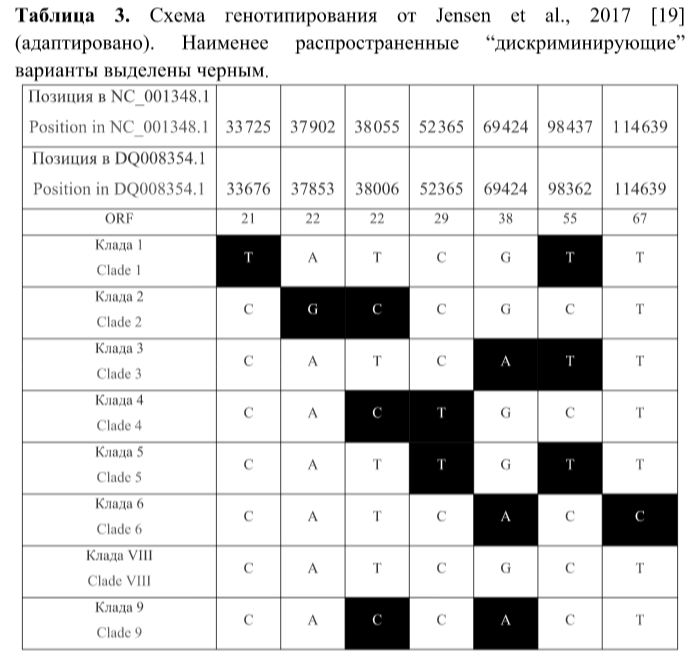

In [13]:
consensuses_by_ref["NC_001348.1"][:, 0:1000]

array([['g', 'g', 'c', ..., 'a', 'g', 't'],
       ['g', 'g', 'c', ..., 'a', 'g', 't'],
       ['g', 'g', 'g', ..., 'a', 'g', 't'],
       ...,
       ['g', 'g', 'c', ..., 'a', 'g', 't'],
       ['a', 'g', 'g', ..., 'a', 'g', 't'],
       ['a', 'g', 'c', ..., 'a', 'g', 't']], dtype='<U1')

In [14]:
consensuses_np_by_ref = {}
for to_ref in ASSEMBLING.glob("*.fasta"):
    consensuses_np = np.stack([np.load(to_consensus) for to_consensus in sorted(CONSENSUSES.joinpath(to_ref.stem).glob("*consensus.npy"))])
    consensuses_np_by_ref[to_ref.stem] = consensuses_np

In [15]:
consensuses_np_by_ref["NC_001348.1"][:, 0:1000]

array([[103, 103,  99, ...,  97, 103, 116],
       [103, 103,  99, ...,  97, 103, 116],
       [103, 103, 103, ...,  97, 103, 116],
       ...,
       [103, 103,  99, ...,  97, 103, 116],
       [ 97, 103, 103, ...,  97, 103, 116],
       [ 97, 103,  99, ...,  97, 103, 116]], dtype=int8)

In [16]:
def are_all_rows_unique(array):
    unique_rows = np.unique(array, axis=0)
    return unique_rows.shape[0] == array.shape[0]

In [17]:
are_all_rows_unique(consensuses_by_ref["NC_001348.1"][:, positions])

True

In [18]:
are_all_rows_unique(consensuses_np_by_ref["NC_001348.1"][:, 0:1000])

False

In [19]:
consensuses_np_by_ref["NC_001348.1"].shape[1]

124884

In [20]:
def create_distance_matrix(array):
    # Создание массива для хранения расстояний между строками
    num_rows, num_columns = array.shape
    distances = np.zeros((num_rows, num_rows), dtype="int8")

    # Вычисление расстояний между строками
    for i in range(num_rows):
        for j in range(i + 1, num_rows):
            distances[i, j] = editdistance.eval(array[i], array[j])
            distances[j, i] = distances[i, j]  # расстояние Левенштейна симметрично
    return distances

In [21]:
create_distance_matrix(consensuses_by_ref["NC_001348.1"][:, positions]).sum()

156

In [35]:
%%time
create_distance_matrix(consensuses_by_ref["NC_001348.1"][:, 0:1000]).sum()

CPU times: user 230 ms, sys: 808 µs, total: 230 ms
Wall time: 227 ms


326

In [23]:
create_distance_matrix(consensuses_by_ref["NC_001348.1"][:, 13101:14101]).sum()

1902

In [92]:
def check_region(array): 
    identity = np.unique(array, axis=0, return_counts=True)[1].shape[0]
    return identity

def check_primers_region(array):
    left_area = np.unique(consensuses_by_ref["NC_001348.1"][:, 0:1000][:, :20], axis=0, return_counts=True)[1].shape[0]
    right_area = np.unique(consensuses_by_ref["NC_001348.1"][:, 0:1000][:, :-20], axis=0, return_counts=True)[1].shape[0]
    
    left_res = np.unique(left_area, axis=0, return_counts=True)[1].shape[0]
    right_res = np.unique(right_area, axis=0, return_counts=True)[1].shape[0]
    return (left_res, right_res)

In [52]:
consensuses_by_ref["NC_001348.1"][:, 0:1000][:, :20]
consensuses_by_ref["NC_001348.1"][:, 0:1000][:, -20:]

array([['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't'],
       ['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't'],
       ['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't'],
       ['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't'],
       ['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't'],
       ['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't'],
       ['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't'],
       ['a', 't', 'g', 't', 'g', 'c', 'g', 'a', 't', 'a', 'c', 'a', 't',
        'c', 't', 't', 'a', 'a', 'g', 't']], dtype='<U1')

In [61]:
consensuses_by_ref["NC_001348.1"][:, positions]

array([['t', 'a', 't', 'c', 'g', 't', 't'],
       ['c', 'g', 'c', 'c', 'g', 'c', 't'],
       ['c', 'a', 't', 'c', 'a', 't', 't'],
       ['c', 'a', 'c', 't', 'g', 'c', 't'],
       ['c', 'a', 't', 't', 'g', 't', 't'],
       ['c', 'a', 't', 'c', 'a', 'c', 'c'],
       ['c', 'a', 't', 'c', 'g', 'c', 't'],
       ['c', 'a', 'c', 'c', 'a', 'c', 't']], dtype='<U1')

In [90]:
#Если равно единице, то это полностью идентиный участок для всех консенсусов
#В данном случае = 3. Это значит, что есть 3 различных варианта последовательностей на этом участке
np.unique(consensuses_by_ref["NC_001348.1"][:, 20:100], axis=0, return_counts=True)[1].shape[0]

3

In [203]:
to_bed = BED / f"insertion_regions-NC_001348.1.bed"
insertion_regions = pybedtools.BedTool(to_bed)
insertion_regions = insertion_regions.sort()

In [206]:
def job(start, window, primary_array):
    if are_all_rows_unique(primary_array[:, start:start+window]):
        primers_area = pybedtools.BedTool(f'''
                                NC_001348.1 {start} {start+20}
                                NC_001348.1 {start+window-20} {start+window}
                               ''', from_string=True)
        number_of_insertion_problems = primers_area.intersect(insertion_regions).count()
        
        left_area = primary_array[:, start:start+window][:, :20]
        right_area = primary_array[:, start:start+window][:, :-20]
        left_score, right_score = check_region(left_area), check_region(right_area)

        total_distance = create_distance_matrix(primary_array[:, start:start+window]).sum()
        record = SeqRecord(seq=ref_NC.seq[start:start+window], id=f"region {start}:{start+window} in NC_001348.1")
        to_save = PREPROCESSING / "selection_of_unique_region" / f"window_{window}" / f"{number_of_insertion_problems}_insertion_problems" / f"l_score_{left_score}-r_score_{right_score}" / f"total_dist-{total_distance}" / f"region-{start}:{start+window}.fasta"
        if to_save.exists():
            print(f"{to_save.name} exists")
            return
        to_save.parent.mkdir(exist_ok=True, parents=True)
        SeqIO.write(record, to_save, "fasta")

In [207]:
%%time
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(job)(start, window=1000, primary_array=consensuses_np_by_ref["NC_001348.1"])
        for start in range(consensuses_np_by_ref["NC_001348.1"].shape[1]-1)
    )

CPU times: user 9min 11s, sys: 1min 29s, total: 10min 40s
Wall time: 11min 25s


In [191]:
to_align = Path("../data/alignments/NC_001348.1/clade_1-merge_align.fasta")
a = alignment_to_np(to_align)
a_copy = a.copy()
b = delete_insertions(a)
c = to_consensus(b).mode

In [192]:
a.shape, b.shape

((20, 127395), (20, 124884))

In [193]:
np.where(a[0] == 45)[0]

array([   108,  13954,  13955, ..., 123154, 123156, 127352])

In [196]:
np.where(a[0] == 45)[0].shape

(2511,)

In [194]:
np.where(b[0] == 45)[0]

array([], dtype=int64)

In [197]:
insertion_coordinats_finder(a[0])

array([   108,  13953,  13953, ..., 120646, 120647, 124842])

In [198]:
insertion_coordinats_finder(a[0]).shape

(2511,)

In [138]:
np.frombuffer("-".encode('utf-8'), dtype=np.int8)

array([45], dtype=int8)

In [141]:
b"45".decode("utf-8")

'45'